## Validate Dropout implementation

In [1]:
# dependencies
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch.optim as optim
import time


from implementation.dropout import Dropout
from utils.tensor_loader import FastTensorDataLoader
from utils.plots import plot_dropout_histories, summarize_metrics

np.random.seed(42)
torch.manual_seed(42)

## Simple Distribution Validation
Test to see if both standard and inverted dropout show expected results

In [2]:
p = 0.5
input_tensor = torch.ones(500, 500) 

# inverted
drop_inv = Dropout(p=p, mode="inverted")
drop_inv.train()
out_inv = drop_inv(input_tensor)
# 50% is dropped. The mean would be 0.5, but scaling should make it close to 1
print(f"Inverted (Train) Mean: {out_inv.mean():.4f} (Expected ~1.0)")
    
drop_inv.eval()
out_inv_eval = drop_inv(input_tensor)
print(f"Inverted (Eval)  Mean: {out_inv_eval.mean():.4f} (Expected 1.0)\n")

# standard
drop_std = Dropout(p=p, mode="standard")
drop_std.train()
out_std = drop_std(input_tensor)
print(f"Standard (Train) Mean: {out_std.mean():.4f} (Expected ~0.5)")
    
drop_std.eval()
out_std_eval = drop_std(input_tensor)
# Tensors are not dropped. The mean would be 1.0, but scaling should make it close to 0.5
print(f"Standard (Eval)  Mean: {out_std_eval.mean():.4f} (Expected 0.5)")

Inverted (Train) Mean: 1.0004 (Expected ~1.0)
Inverted (Eval)  Mean: 1.0000 (Expected 1.0)

Standard (Train) Mean: 0.5001 (Expected ~0.5)
Standard (Eval)  Mean: 0.5000 (Expected 0.5)


## Loading Fashion-MNIST

In [3]:
# import dataset
train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

train[0][0].shape, train[0][1]

(torch.Size([1, 28, 28]), 9)

In [4]:
train.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Text(0.5, 1.0, '9')

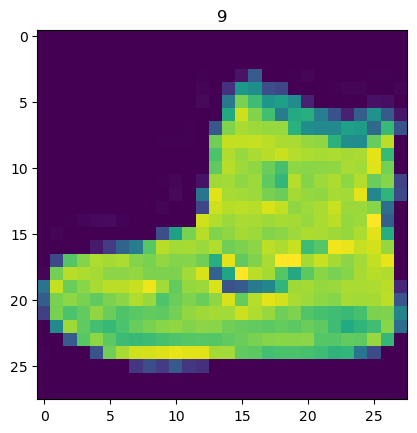

In [5]:
image, label = train[0]
plt.imshow(image.squeeze())
plt.title(label)

## Validate Dropout Using Different Models

In [6]:
# create fast dataloaders (avoid using if not enough vram)
train_loader = FastTensorDataLoader(train, shuffle=True)
test_loader = FastTensorDataLoader(test, shuffle=False)

In [7]:
from nn_models.simple import SimpleDropoutNetwork
from nn_models.lenet import DropoutLeNet
from nn_models.vgg import DropoutVGG
from utils.validate import train_and_validate

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dropout_models = [
    SimpleDropoutNetwork,
    DropoutLeNet,
    #DropoutVGG
]

dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

results = {}

for dropout_model in dropout_models:
    for p in dropout_rates:
        print(f"\nTesting Dropout p={p}")
        model = dropout_model(dropout_rate=p, dropout_mode="inverted", input_channels=1, img_size=28).to(device)
        history = train_and_validate(model, train_loader, test_loader, epochs=60, max_norm=3.0) #TODO: testar outros valores max_norm? (ex: None, 4.0)
        try:
            results[model.name][p] = history
        except:
            results[model.name] = {}
            results[model.name][p] = history


Testing Dropout p=0.0


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 23.38it/s]


Finished in 2.57s

Testing Dropout p=0.2


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:05<00:00, 11.70it/s]


Finished in 5.13s

Testing Dropout p=0.4


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:06<00:00,  9.33it/s]


Finished in 6.43s

Testing Dropout p=0.6


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:06<00:00,  9.17it/s]


Finished in 6.54s

Testing Dropout p=0.8


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:06<00:00,  8.98it/s]


Finished in 6.69s

Testing Dropout p=0.0


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Finished in 12.68s

Testing Dropout p=0.2


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:15<00:00,  3.78it/s]


Finished in 15.86s

Testing Dropout p=0.4


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:16<00:00,  3.69it/s]


Finished in 16.28s

Testing Dropout p=0.6


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:23<00:00,  2.61it/s]


Finished in 23.01s

Testing Dropout p=0.8


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:25<00:00,  2.32it/s]

Finished in 25.86s


In [8]:
summarize_metrics(results)

,Model,Dropout Rate,Test Acc (%),F1 Score,Test Loss
5,LeNet Dropout Neural Network,0.0000,89.6000,0.8938,0.2931
6,LeNet Dropout Neural Network,0.2000,90.6400,0.9054,0.2708
7,LeNet Dropout Neural Network,0.4000,90.2400,0.9016,0.2736
8,LeNet Dropout Neural Network,0.6000,89.3200,0.8920,0.2980
9,LeNet Dropout Neural Network,0.8000,84.6000,0.8379,0.4436
0,Simple Dropout Neural Network,0.0000,89.2800,0.8934,0.4201
1,Simple Dropout Neural Network,0.2000,90.1500,0.9010,0.3649
2,Simple Dropout Neural Network,0.4000,89.9200,0.8988,0.3152
3,Simple Dropout Neural Network,0.6000,89.4700,0.8942,0.3046
4,Simple Dropout Neural Network,0.8000,87.8900,0.8776,0.3435


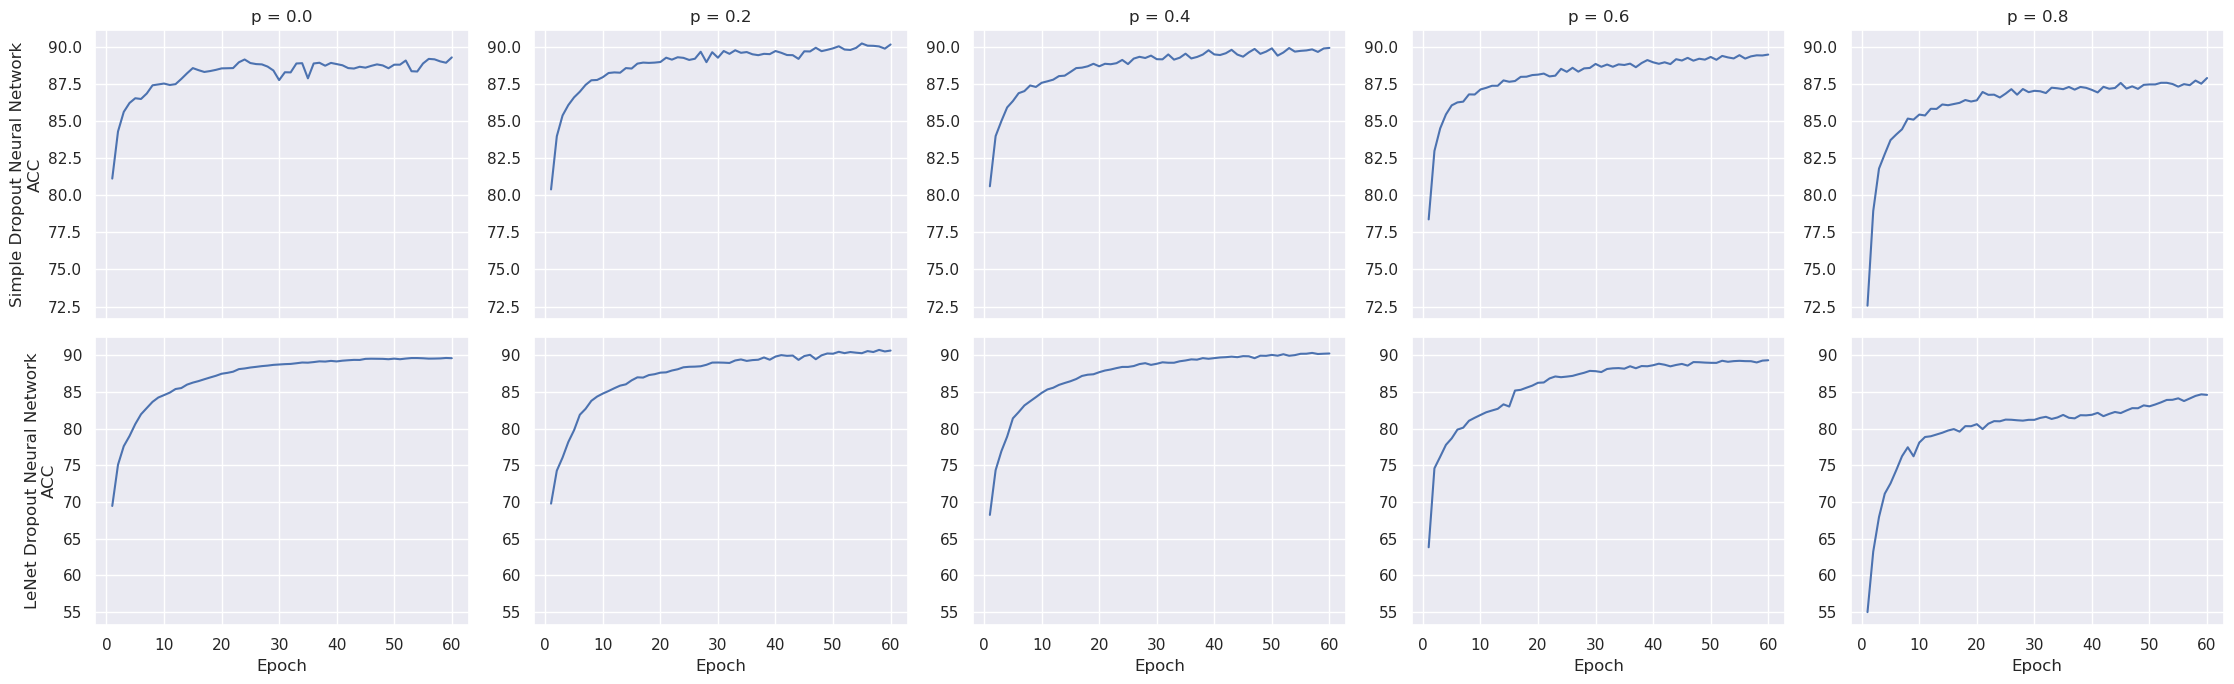

In [9]:
plot_dropout_histories(results, metric="acc")

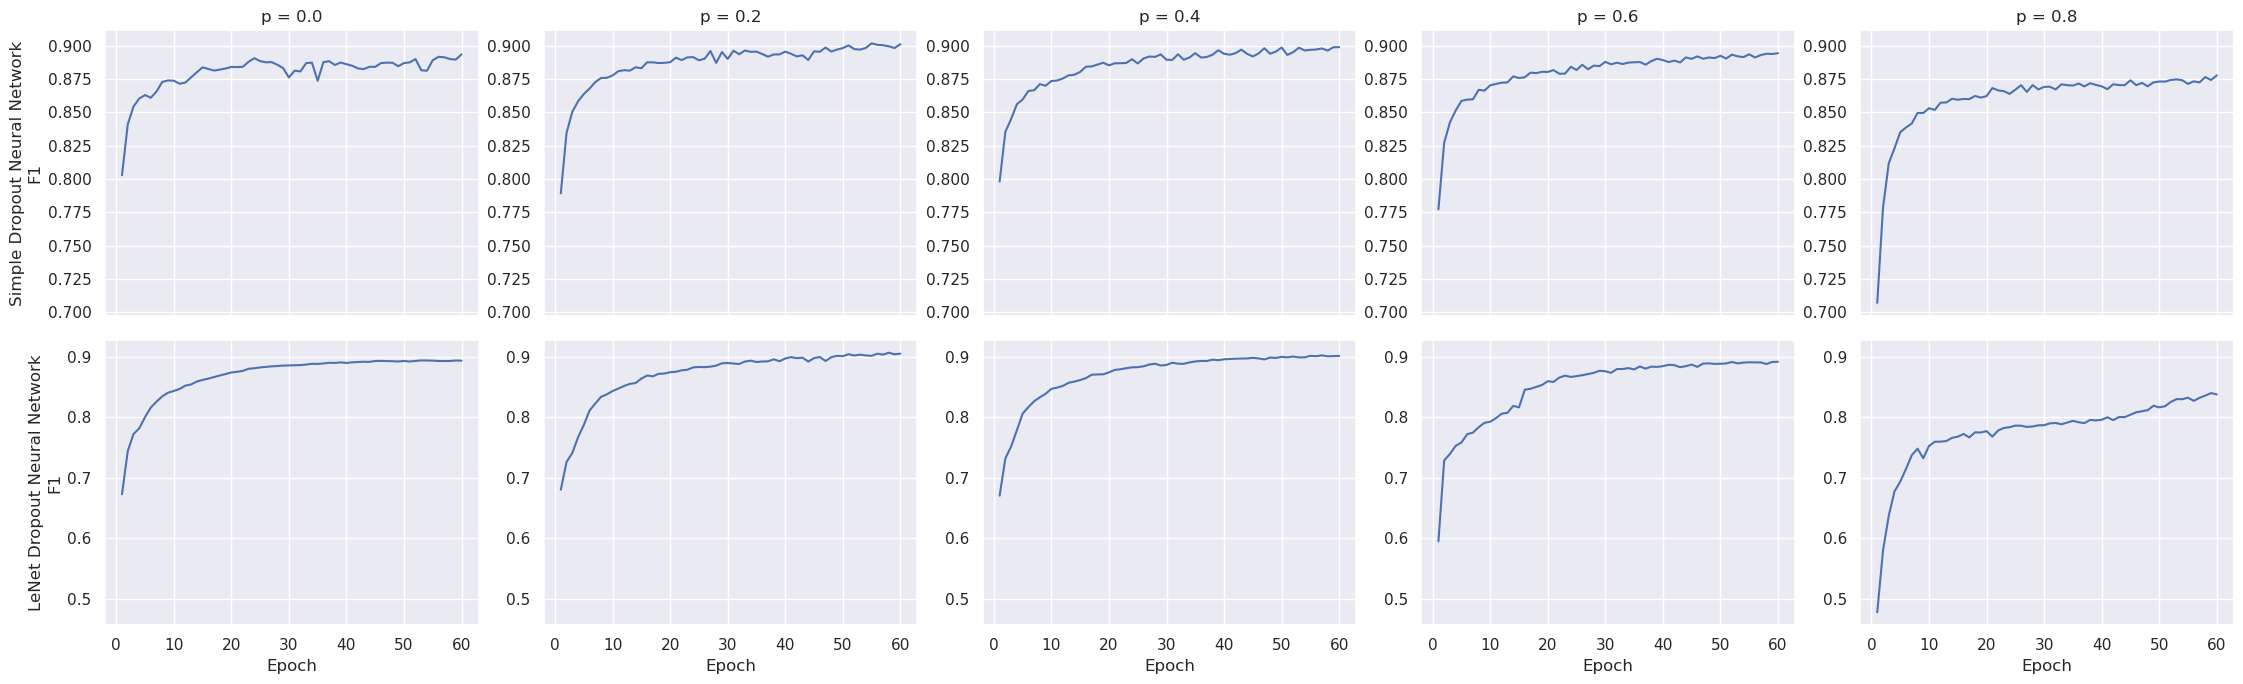

In [10]:
plot_dropout_histories(results, metric="f1")

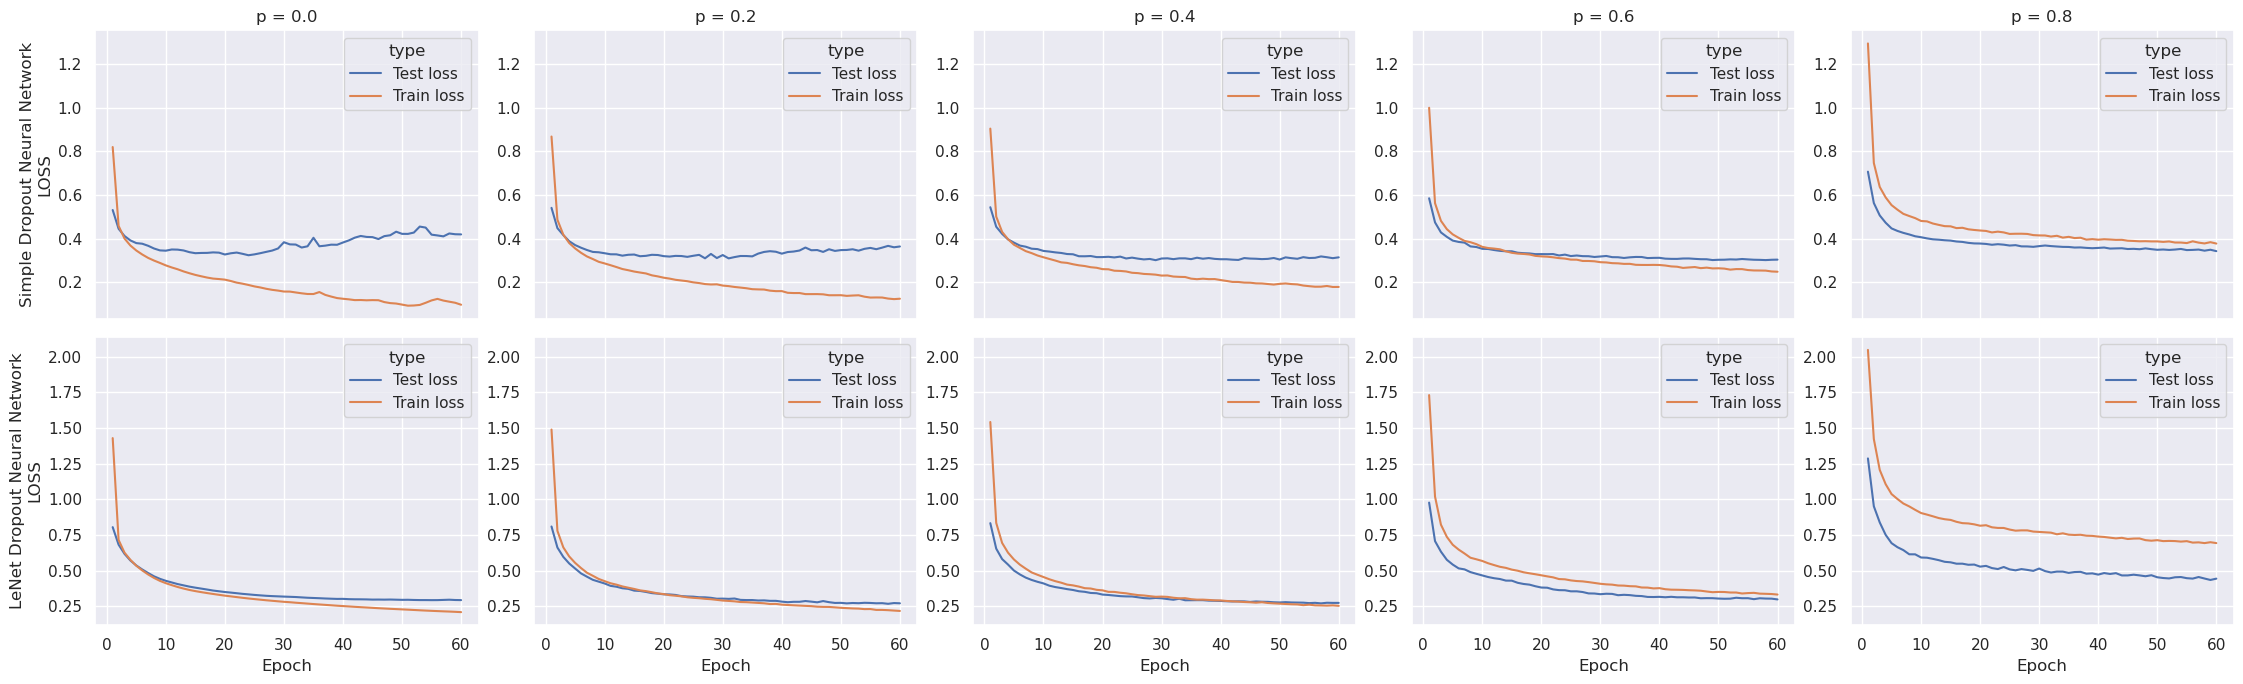

In [11]:
plot_dropout_histories(results, metric="loss")

## Training with Subset

In [12]:
len(train)

60000

In [13]:
indices = np.random.choice(len(train), size=1000, replace=False)
train_subset = Subset(train, indices)

train_loader_small = FastTensorDataLoader(train_subset, shuffle=True, batch_size=4096)

In [14]:
results_small = {}

for dropout_model in dropout_models:
    for p in dropout_rates:
        print(f"\nTesting Dropout p={p}")
        model = dropout_model(dropout_rate=p, dropout_mode="inverted", input_channels=1, img_size=28).to(device)
        history = train_and_validate(model, train_loader_small, test_loader, epochs=60, max_norm=3.0)
        try:
            results_small[model.name][p] = history
        except:
            results_small[model.name] = {}
            results_small[model.name][p] = history


Testing Dropout p=0.0


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 22.13it/s]


Finished in 2.71s

Testing Dropout p=0.2


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 21.92it/s]


Finished in 2.74s

Testing Dropout p=0.4


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 21.64it/s]


Finished in 2.77s

Testing Dropout p=0.6


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 22.11it/s]


Finished in 2.71s

Testing Dropout p=0.8


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 22.48it/s]


Finished in 2.67s

Testing Dropout p=0.0


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:03<00:00, 18.95it/s]


Finished in 3.17s

Testing Dropout p=0.2


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:03<00:00, 18.49it/s]


Finished in 3.25s

Testing Dropout p=0.4


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:03<00:00, 18.32it/s]


Finished in 3.28s

Testing Dropout p=0.6


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:03<00:00, 18.50it/s]


Finished in 3.24s

Testing Dropout p=0.8


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:03<00:00, 18.59it/s]

Finished in 3.23s


In [15]:
summarize_metrics(results_small)

,Model,Dropout Rate,Test Acc (%),F1 Score,Test Loss
5,LeNet Dropout Neural Network,0.0000,73.0500,0.7219,0.7732
6,LeNet Dropout Neural Network,0.2000,71.7900,0.6990,0.7754
7,LeNet Dropout Neural Network,0.4000,71.9200,0.6931,0.7731
8,LeNet Dropout Neural Network,0.6000,66.7000,0.6419,0.9123
9,LeNet Dropout Neural Network,0.8000,57.7100,0.5417,1.2729
0,Simple Dropout Neural Network,0.0000,80.5200,0.8069,0.6367
1,Simple Dropout Neural Network,0.2000,80.6800,0.8063,0.6067
2,Simple Dropout Neural Network,0.4000,80.6600,0.8069,0.5959
3,Simple Dropout Neural Network,0.6000,79.3100,0.7899,0.6079
4,Simple Dropout Neural Network,0.8000,73.9600,0.7230,0.6913


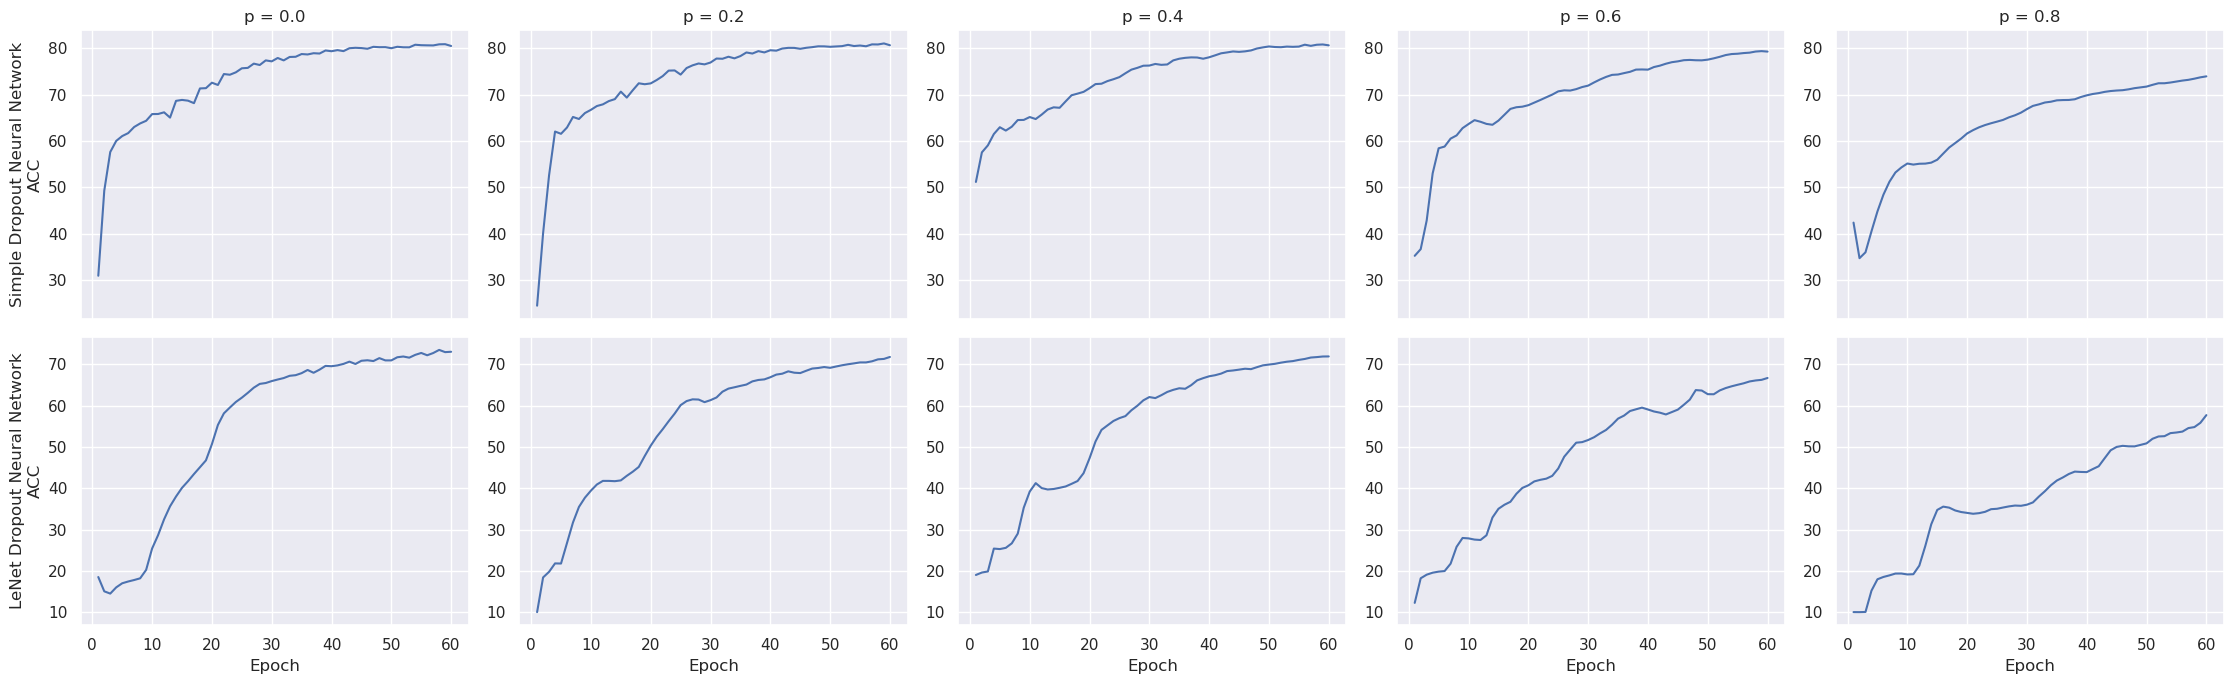

In [16]:
plot_dropout_histories(results_small, metric="acc")

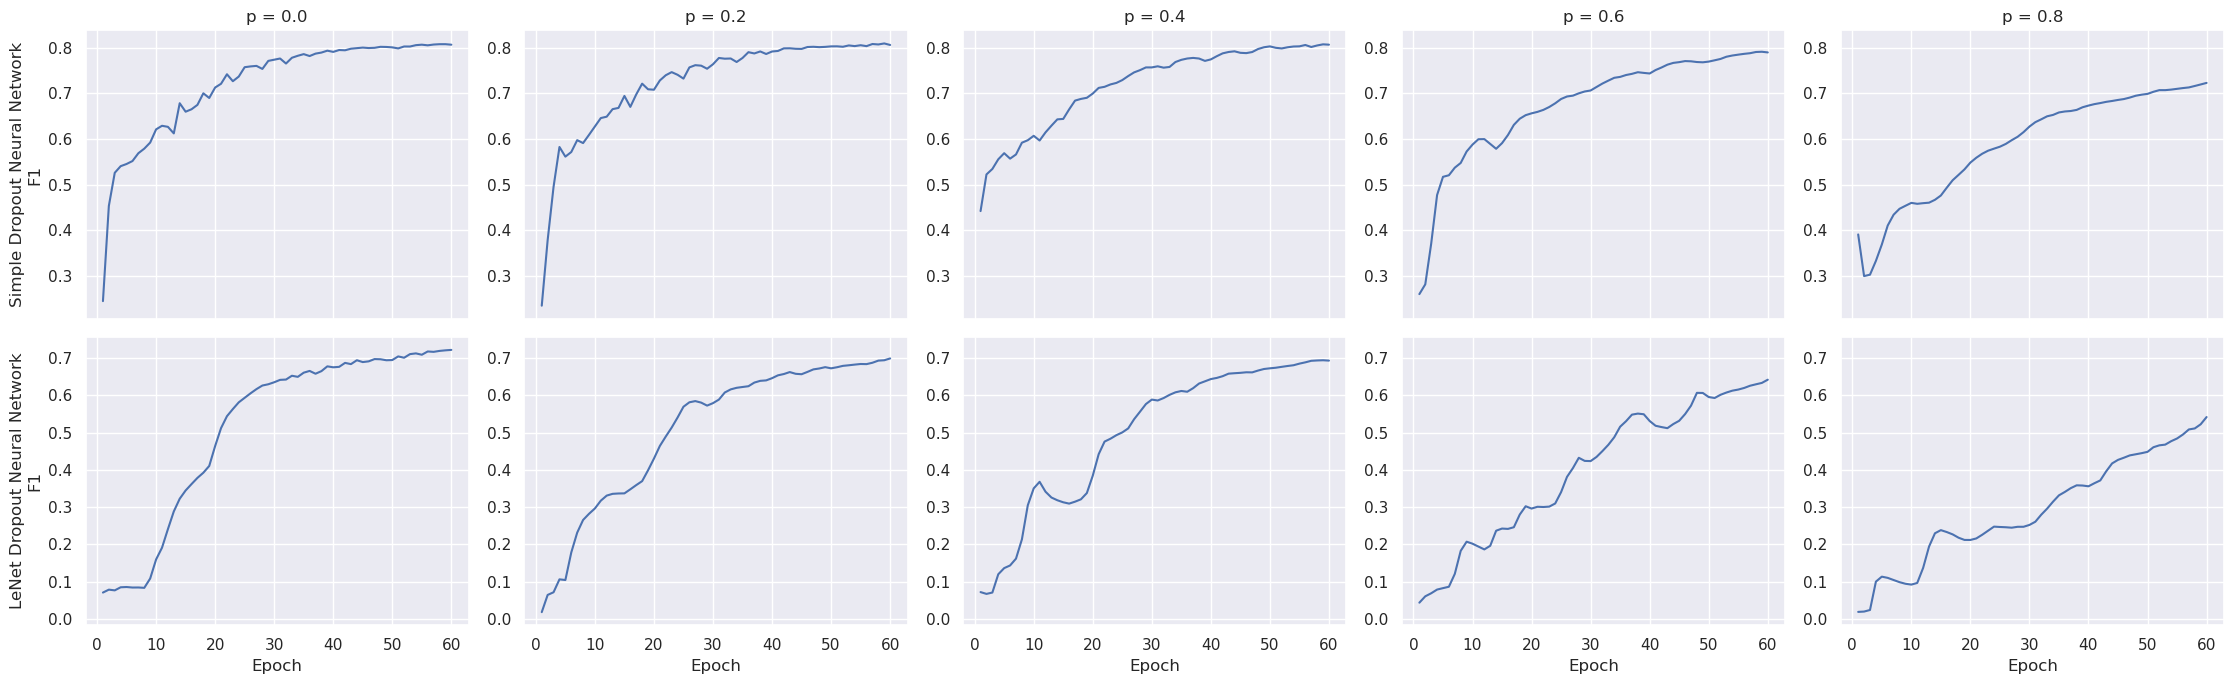

In [17]:
plot_dropout_histories(results_small, metric="f1")

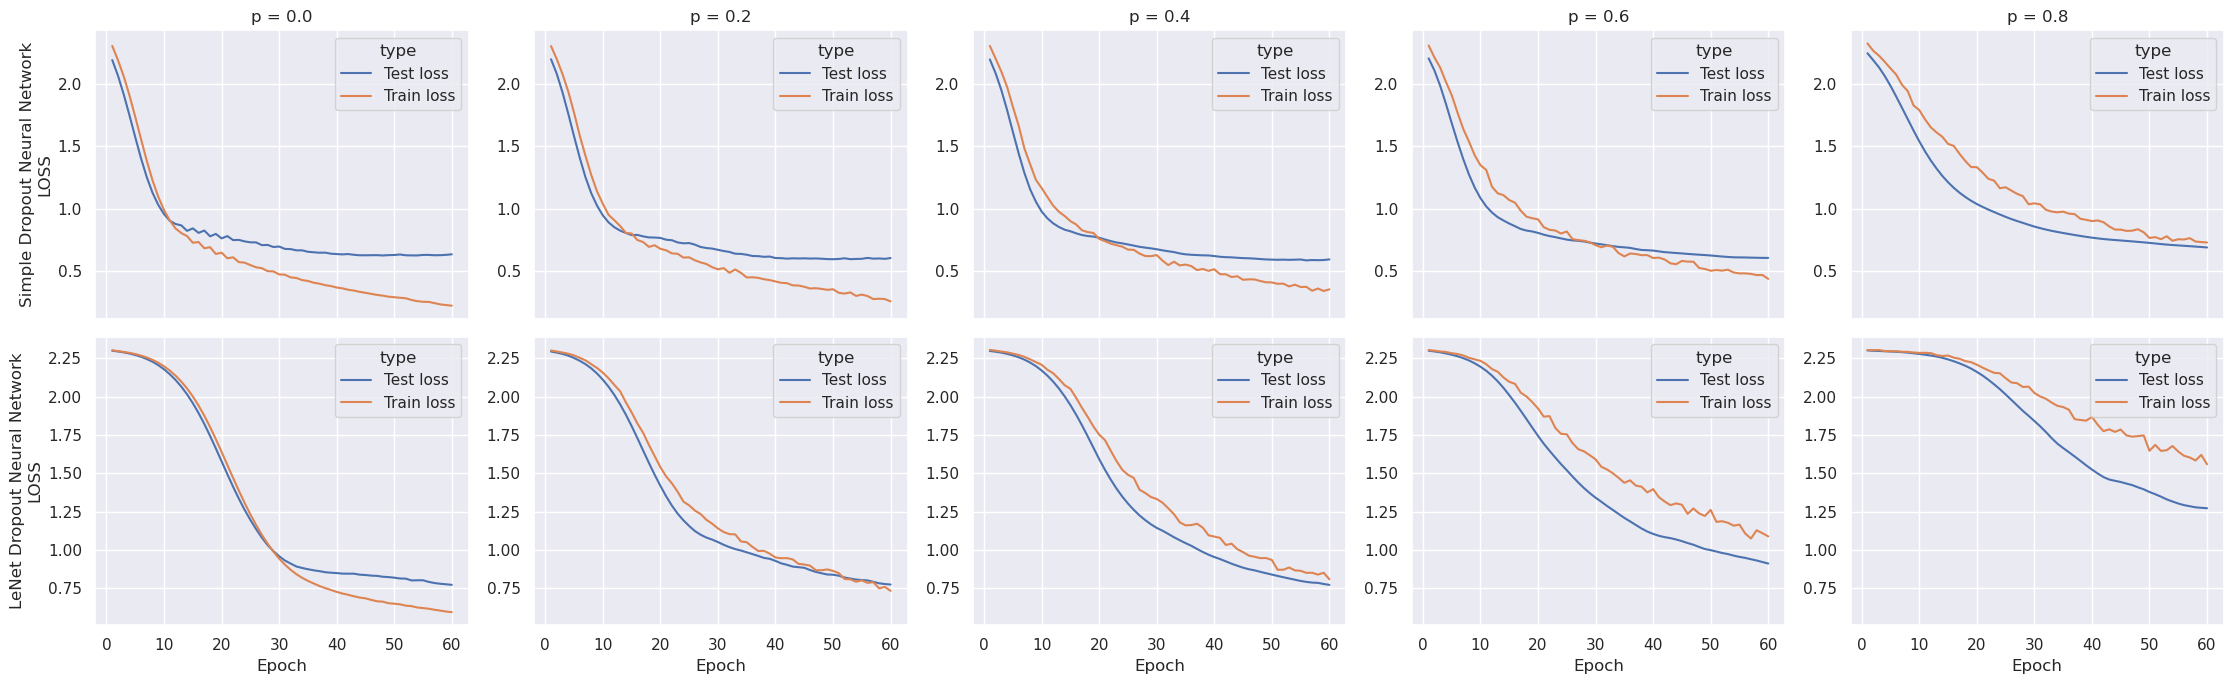

In [18]:
plot_dropout_histories(results_small, metric="loss")

## Training with Noise

In [19]:
len(train)

60000

In [20]:
# create noise
noise_level = 0.1
num_corrupted = int(len(train) * noise_level)

corrupt_indices = torch.randperm(len(train))[:num_corrupted]
train_loader.targets[corrupt_indices] = torch.randint(
    0, 10, (num_corrupted,), device=device
)

In [21]:
results = {}

for dropout_model in dropout_models:
    for p in dropout_rates:
        print(f"\nTesting Dropout p={p}")
        model = dropout_model(dropout_rate=p, dropout_mode="inverted", input_channels=1, img_size=28).to(device)
        history = train_and_validate(model, train_loader, test_loader, epochs=100, max_norm=3.0) #TODO: testar outros valores max_norm? (ex: None, 4.0)
        try:
            results[model.name][p] = history
        except:
            results[model.name] = {}
            results[model.name][p] = history


Testing Dropout p=0.0


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


Finished in 19.93s

Testing Dropout p=0.2


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


Finished in 20.26s

Testing Dropout p=0.4


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


Finished in 20.23s

Testing Dropout p=0.6


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


Finished in 20.25s

Testing Dropout p=0.8


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


Finished in 20.36s

Testing Dropout p=0.0


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


Finished in 22.78s

Testing Dropout p=0.2


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


Finished in 22.28s

Testing Dropout p=0.4


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


Finished in 31.06s

Testing Dropout p=0.6


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


Finished in 43.17s

Testing Dropout p=0.8


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:42<00:00,  2.33it/s]

Finished in 42.90s


In [22]:
summarize_metrics(results)

,Model,Dropout Rate,Test Acc (%),F1 Score,Test Loss
5,LeNet Dropout Neural Network,0.0000,89.1200,0.8893,0.3724
6,LeNet Dropout Neural Network,0.2000,90.1100,0.9011,0.3386
7,LeNet Dropout Neural Network,0.4000,90.4100,0.9038,0.3320
8,LeNet Dropout Neural Network,0.6000,89.3900,0.8923,0.3534
9,LeNet Dropout Neural Network,0.8000,88.1100,0.8745,0.4495
0,Simple Dropout Neural Network,0.0000,85.5100,0.8534,0.7237
1,Simple Dropout Neural Network,0.2000,88.4300,0.8840,0.4283
2,Simple Dropout Neural Network,0.4000,88.9300,0.8892,0.3654
3,Simple Dropout Neural Network,0.6000,88.9300,0.8887,0.3657
4,Simple Dropout Neural Network,0.8000,87.4400,0.8728,0.4191


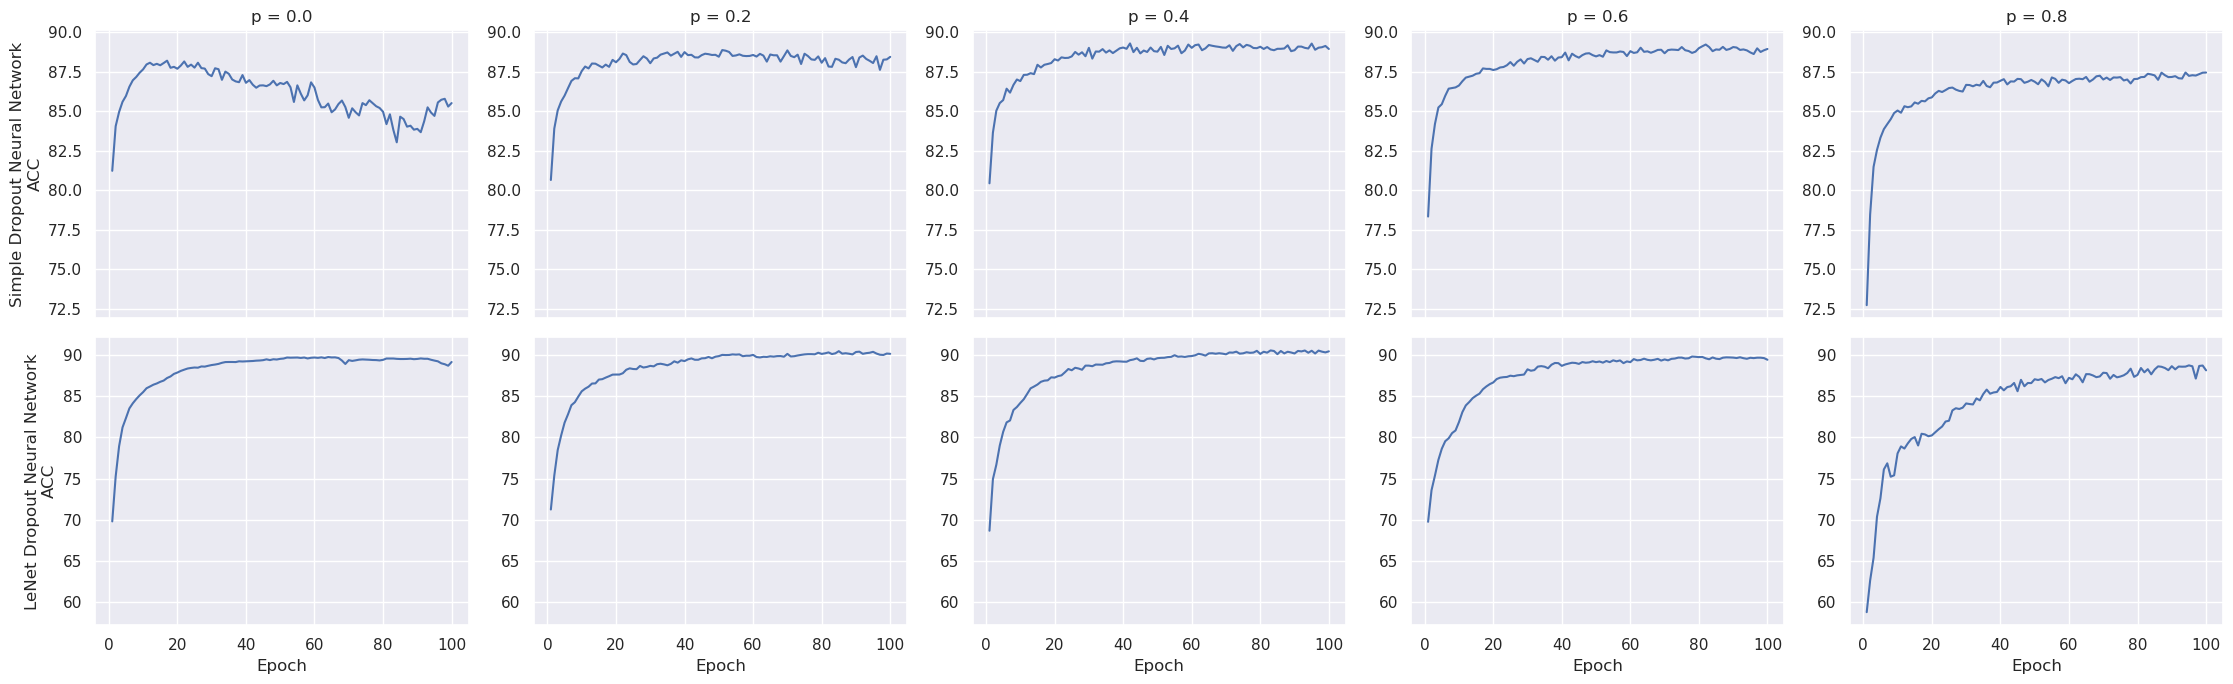

In [23]:
plot_dropout_histories(results, metric="acc")

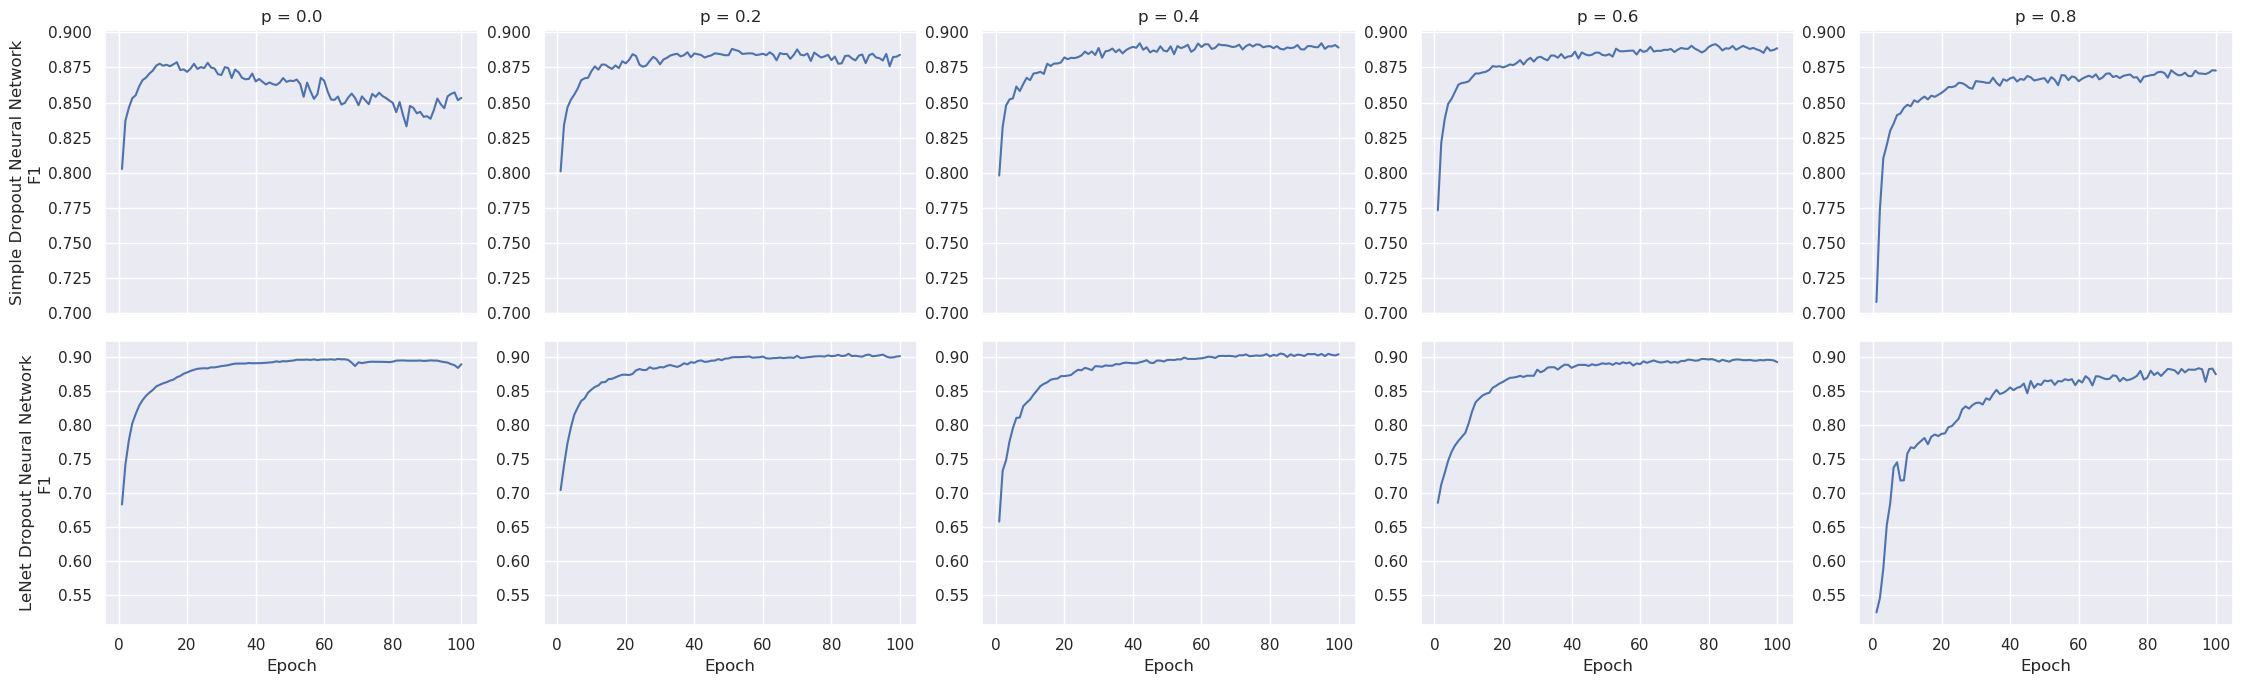

In [24]:
plot_dropout_histories(results, metric="f1")

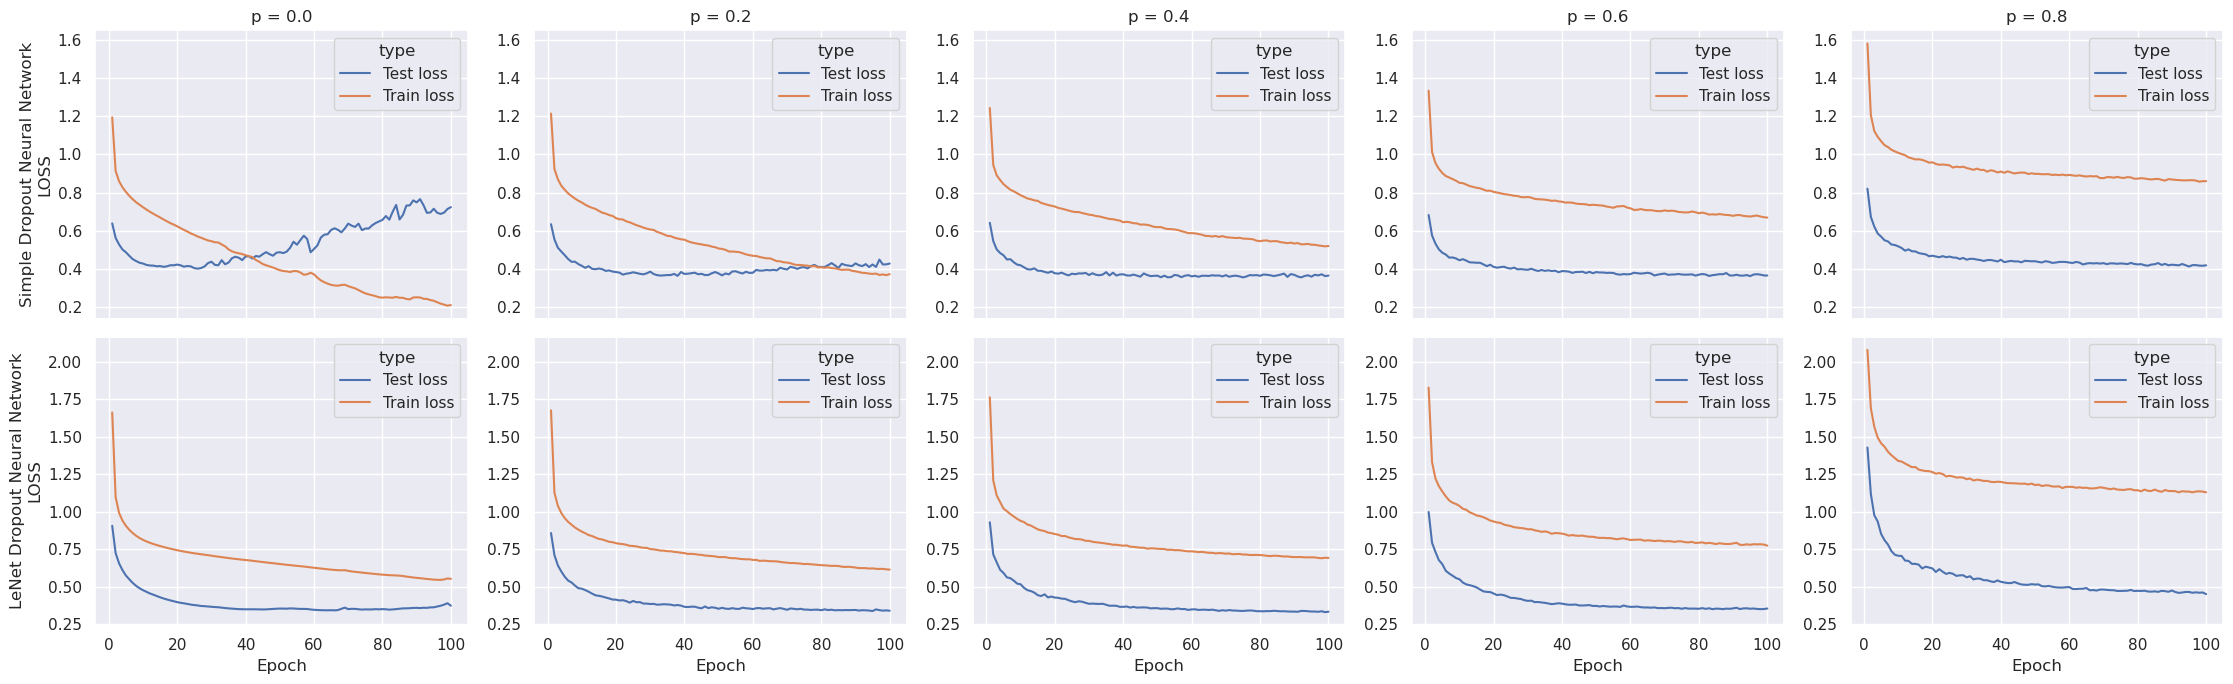

In [25]:
plot_dropout_histories(results, metric="loss")